Goal: Build machine learning to predicts categories

Models trained:
- Random Forest CLassifier
- Logistic Regression

Tasks
- Analyze & data preparation
- Engineer features
- train & compare models
- suggest improvements

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

Load the Datasets and explore the first few rows of the datasets

In [10]:
transactions = pd.read_csv('Data/bank_transaction.csv')
profiles = pd.read_csv('Data/user_profile.csv')

transactions.head(), profiles.head()

(   client_id  bank_id  account_id  txn_id         txn_date  \
 0          1        1           1       4  29/09/2023 0:00   
 1          1        1           1       3  14/08/2023 0:00   
 2          1        1           1       5  25/09/2023 0:00   
 3          1        1           2       1  02/06/2023 0:00   
 4          1        1           2       2  01/06/2023 0:00   
 
                                          description  amount         category  
 0  Earnin           PAYMENT                 Donat...    20.0            Loans  
 1  ONLINE TRANSFER FROM NDonatas DanyalDA O CARSO...    25.0  Transfer Credit  
 2  MONEY TRANSFER                          AUTHOR...    20.0            Loans  
 3  ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...    16.0  Transfer Credit  
 4  ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...     4.0  Transfer Credit  ,
    CLIENT_ID  IS_INTERESTED_INVESTMENT  IS_INTERESTED_BUILD_CREDIT  \
 0          1                     False                       

Exploring data types and missing values

In [11]:
transactions.info(),
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258779 entries, 0 to 258778
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   client_id    258779 non-null  int64  
 1   bank_id      258779 non-null  int64  
 2   account_id   258779 non-null  int64  
 3   txn_id       258779 non-null  int64  
 4   txn_date     258779 non-null  object 
 5   description  258779 non-null  object 
 6   amount       258779 non-null  float64
 7   category     258522 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 15.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   CLIENT_ID                      1000 non-null   int64
 1   IS_INTERESTED_INVESTMENT       1000 non-null   bool 
 2   IS_INTERESTED_BUILD_CREDIT     1000 non-null   bool 
 3

In [12]:
transactions.isnull().sum(), profiles.isnull().sum()

(client_id        0
 bank_id          0
 account_id       0
 txn_id           0
 txn_date         0
 description      0
 amount           0
 category       257
 dtype: int64,
 CLIENT_ID                        0
 IS_INTERESTED_INVESTMENT         0
 IS_INTERESTED_BUILD_CREDIT       0
 IS_INTERESTED_INCREASE_INCOME    0
 IS_INTERESTED_PAY_OFF_DEBT       0
 IS_INTERESTED_MANAGE_SPENDING    0
 IS_INTERESTED_GROW_SAVINGS       0
 dtype: int64)

So far there are no null values within these datasets

TARGET COLUMN ANALYSIS

In [13]:
transactions['category'].nunique(), #unique categories
transactions['category'].value_counts() #distribution

category
Uncategorized                 29392
Third Party                   28714
Restaurants                   26367
Transfer Credit               21561
Loans                         19605
Convenience Stores            18630
Supermarkets and Groceries    16750
Transfer Debit                15114
Gas Stations                  12919
Internal Account Transfer     11983
Payroll                        8100
Shops                          7418
Bank Fees                      6432
Transfer                       6275
ATM                            5672
Transfer Deposit               4976
Digital Entertainment          4525
Utilities                      4118
Clothing and Accessories       3190
Department Stores              2002
Insurance                      1754
Service                         910
Arts and Entertainment          397
Travel                          367
Food and Beverage Services      343
Interest                        280
Check Deposit                   211
Healthcare         

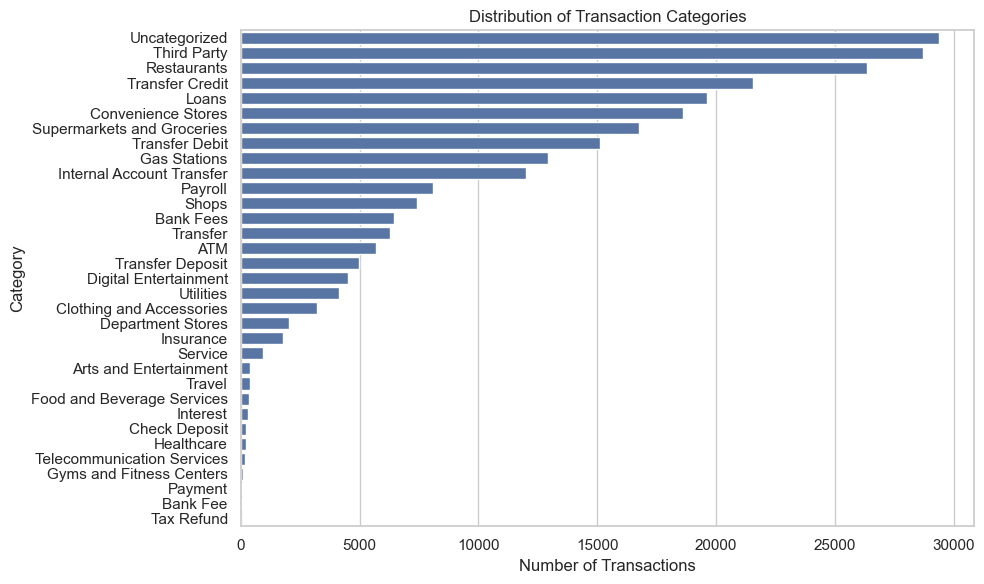

<Axes: title={'center': 'User Financial Interests'}>

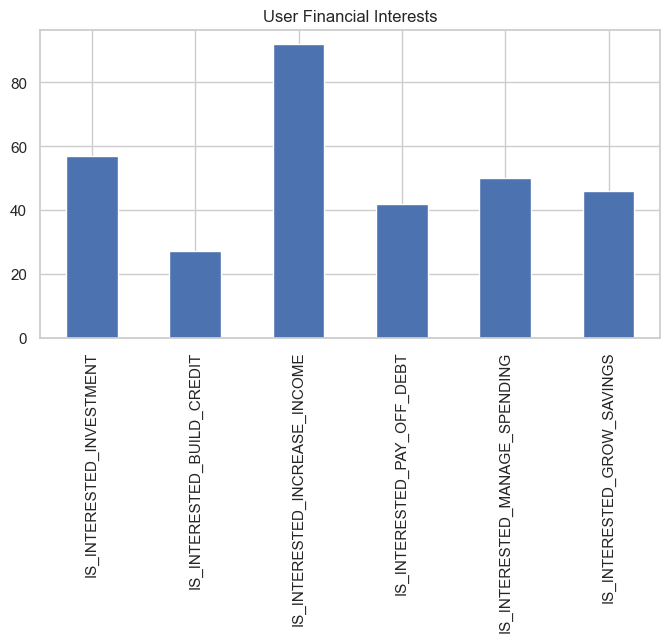

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(data=transactions, y='category', order=transactions['category'].value_counts().index)
plt.title('Distribution of Transaction Categories')
plt.xlabel('Number of Transactions')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

#true values in user_profiles
profiles.drop(columns=['CLIENT_ID']).sum().plot(kind='bar', figsize=(8, 4), title='User Financial Interests')

Category Distribution Analysis

- The top 5 categories that has the highest amount of transactions are
    - Uncategorized
    - Third Party
    - Restaurants
    - Transfer Credit
    - Loans

- This is heavily imbalanced dataset
    - Uncategorized category will be temporarily dropped during training model
    - will use this category again to test the model
    - This dataset might reflect normal human behaviour
        - People will eat at resturants but not necessarily went to gyms
        - the top 3 after uncategorized is because the users perform them regularly
    - might affect model performance since there are categories with small amount of data

User Profile Analysis
- **Interested to increase income** has the most common interest followed by **Interested in investments**
- This hopefully will help to model to understand better on the user's intent with category prediction
- like someone interested in **Grow savings** might deal more with **Transfer Deposit** and/or **Internal Account Transfer**

**MODEL DEVELOPMENT**

I will then use 2 different models and make comparison on which model is better at predicting categories
- Random forest with TF-IDF
- Logistic Regression

My prediction is Random Forest with TF-IDF will perform better than Logistic Regression with these 2 datasets. Yes logistic regression is simpler and faster but not necessarily more accurate. TF-IDF might perform better due to its capabilities dealing with nonlinear patterns

FEATURES ENGINEERING

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer #TF-IDF
from sklearn.preprocessing import LabelEncoder, StandardScaler #for label encoding and scaling
from sklearn.model_selection import train_test_split

In [16]:
transactions = transactions[transactions['category'] != 'Uncategorized'] #drop uncategorized

In [17]:
profiles.rename(columns={'CLIENT_ID': 'client_id'}, inplace=True)
merged = pd.merge(transactions, profiles, on='client_id', how='left')
merged.head()

,client_id,bank_id,account_id,txn_id,txn_date,description,amount,category,IS_INTERESTED_INVESTMENT,IS_INTERESTED_BUILD_CREDIT,IS_INTERESTED_INCREASE_INCOME,IS_INTERESTED_PAY_OFF_DEBT,IS_INTERESTED_MANAGE_SPENDING,IS_INTERESTED_GROW_SAVINGS
0,1,1,1,4,29/09/2023 0:00,Earnin PAYMENT Donat...,20.0,Loans,False,False,False,False,False,False
1,1,1,1,3,14/08/2023 0:00,ONLINE TRANSFER FROM NDonatas DanyalDA O CARSO...,25.0,Transfer Credit,False,False,False,False,False,False
2,1,1,1,5,25/09/2023 0:00,MONEY TRANSFER AUTHOR...,20.0,Loans,False,False,False,False,False,False
3,1,1,2,1,02/06/2023 0:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,16.0,Transfer Credit,False,False,False,False,False,False
4,1,1,2,2,01/06/2023 0:00,ONLINE TRANSFER FROM CARSON N EVERYDAY CHECKIN...,4.0,Transfer Credit,False,False,False,False,False,False


In [18]:
interests_columns = [
    "IS_INTERESTED_INVESTMENT",
    "IS_INTERESTED_BUILD_CREDIT",
    "IS_INTERESTED_INCREASE_INCOME",
    "IS_INTERESTED_PAY_OFF_DEBT",
    "IS_INTERESTED_MANAGE_SPENDING",
    "IS_INTERESTED_GROW_SAVINGS"
    ]
merged[interests_columns] = merged[interests_columns].astype(int)

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=500)
X_text = vectorizer.fit_transform(merged['description'])

#scaling
scaler = StandardScaler()
X_amount = scaler.fit_transform(merged[['amount']].values)

#combine features
X_user = merged[interests_columns].values
X = np.hstack((X_text.toarray(), X_amount, X_user))

#encode target
le = LabelEncoder()
y = le.fit_transform(merged['category'])

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**MODEL TRAINING**

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#randomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
#logistic regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

**MODEL EVALUATION**

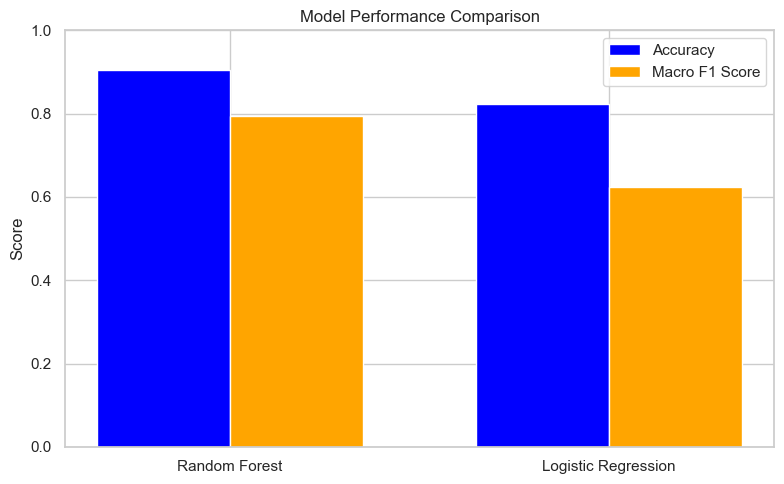

Random Forest Accuracy: 0.9058
Logistic Regression Accuracy: 0.824

Random Forest Macro F1 Report:  0.7937
LogisticRegression Macro F1 Report:  0.6248


In [21]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

#predict (nervewrecking)
y_pred_rf = rf_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)

#metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
rf_macro_f1 = f1_score(y_test, y_pred_rf, average='macro')
lr_macro_f1 = f1_score(y_test, y_pred_lr, average='macro')

#dataframe for metrics
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression'],
    'Accuracy': [rf_accuracy, lr_accuracy],
    'Macro F1 Score': [rf_macro_f1, lr_macro_f1]
})

#plot
plt.figure(figsize=(8, 5))
bar_width = 0.35
x = np.arange(len(metrics_df['Model']))

plt.bar(x - bar_width/2, metrics_df['Accuracy'], width=bar_width, label='Accuracy', color='blue')
plt.bar(x + bar_width/2, metrics_df['Macro F1 Score'], width=bar_width, label='Macro F1 Score', color='orange')

plt.xticks(x, metrics_df['Model'])
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

print("Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4)),
print("Logistic Regression Accuracy:", round(accuracy_score(y_test, y_pred_lr), 4)),

print("\nRandom Forest Macro F1 Report: ", round(f1_score(y_test, y_pred_rf, average='macro'), 4)),
print("LogisticRegression Macro F1 Report: ", round(f1_score(y_test, y_pred_lr, average='macro'), 4))

In [22]:
from sklearn.utils.multiclass import unique_labels
labels_used = unique_labels(y_test, y_pred_rf)
class_names = [str(cls) for cls in le.classes_]

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, labels=labels_used, target_names=class_names))


Random Forest Classification Report:
                            precision    recall  f1-score   support

                       ATM       0.99      1.00      0.99      1150
    Arts and Entertainment       0.95      0.91      0.93        68
                  Bank Fee       1.00      0.50      0.67         6
                 Bank Fees       0.98      0.99      0.99      1275
             Check Deposit       0.95      0.93      0.94        45
  Clothing and Accessories       0.64      0.57      0.60       632
        Convenience Stores       0.85      0.89      0.87      3678
         Department Stores       0.47      0.36      0.41       430
     Digital Entertainment       0.84      0.88      0.86       909
Food and Beverage Services       0.61      0.61      0.61        59
              Gas Stations       0.80      0.82      0.81      2507
  Gyms and Fitness Centers       0.80      0.42      0.55        19
                Healthcare       0.54      0.33      0.41        43
         

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 32, does not match size of target_names, 33
  warnings.warn(


In [23]:
labels_used = unique_labels(y_test, y_pred_lr)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, labels=labels_used, target_names=class_names))

Logistic Regression Classification Report:
                            precision    recall  f1-score   support

                       ATM       0.98      0.98      0.98      1150
    Arts and Entertainment       0.83      0.85      0.84        68
                  Bank Fee       0.00      0.00      0.00         6
                 Bank Fees       0.96      0.97      0.96      1275
             Check Deposit       0.89      0.91      0.90        45
  Clothing and Accessories       0.64      0.53      0.58       632
        Convenience Stores       0.62      0.72      0.67      3678
         Department Stores       0.51      0.07      0.13       430
     Digital Entertainment       0.80      0.77      0.79       909
Food and Beverage Services       0.52      0.27      0.36        59
              Gas Stations       0.55      0.23      0.32      2507
  Gyms and Fitness Centers       0.00      0.00      0.00        19
                Healthcare       0.50      0.05      0.09        43
    

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 32, does not match size of target_names, 33
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-package

Based on these 3 indicators, Random Forest with TF-IDF scores better across the boards

Random Forest with TF-IDF:
- Accuracy = 0.9058
- F1-scores = 0.7937
- Classification = higher scores overall

Logistic Regression:
- Accuracy = 0.824
- F1-scores = 0.6248
- Classification = still high but not as high as RF

Random Forest with TF-IDF will be used for prediction

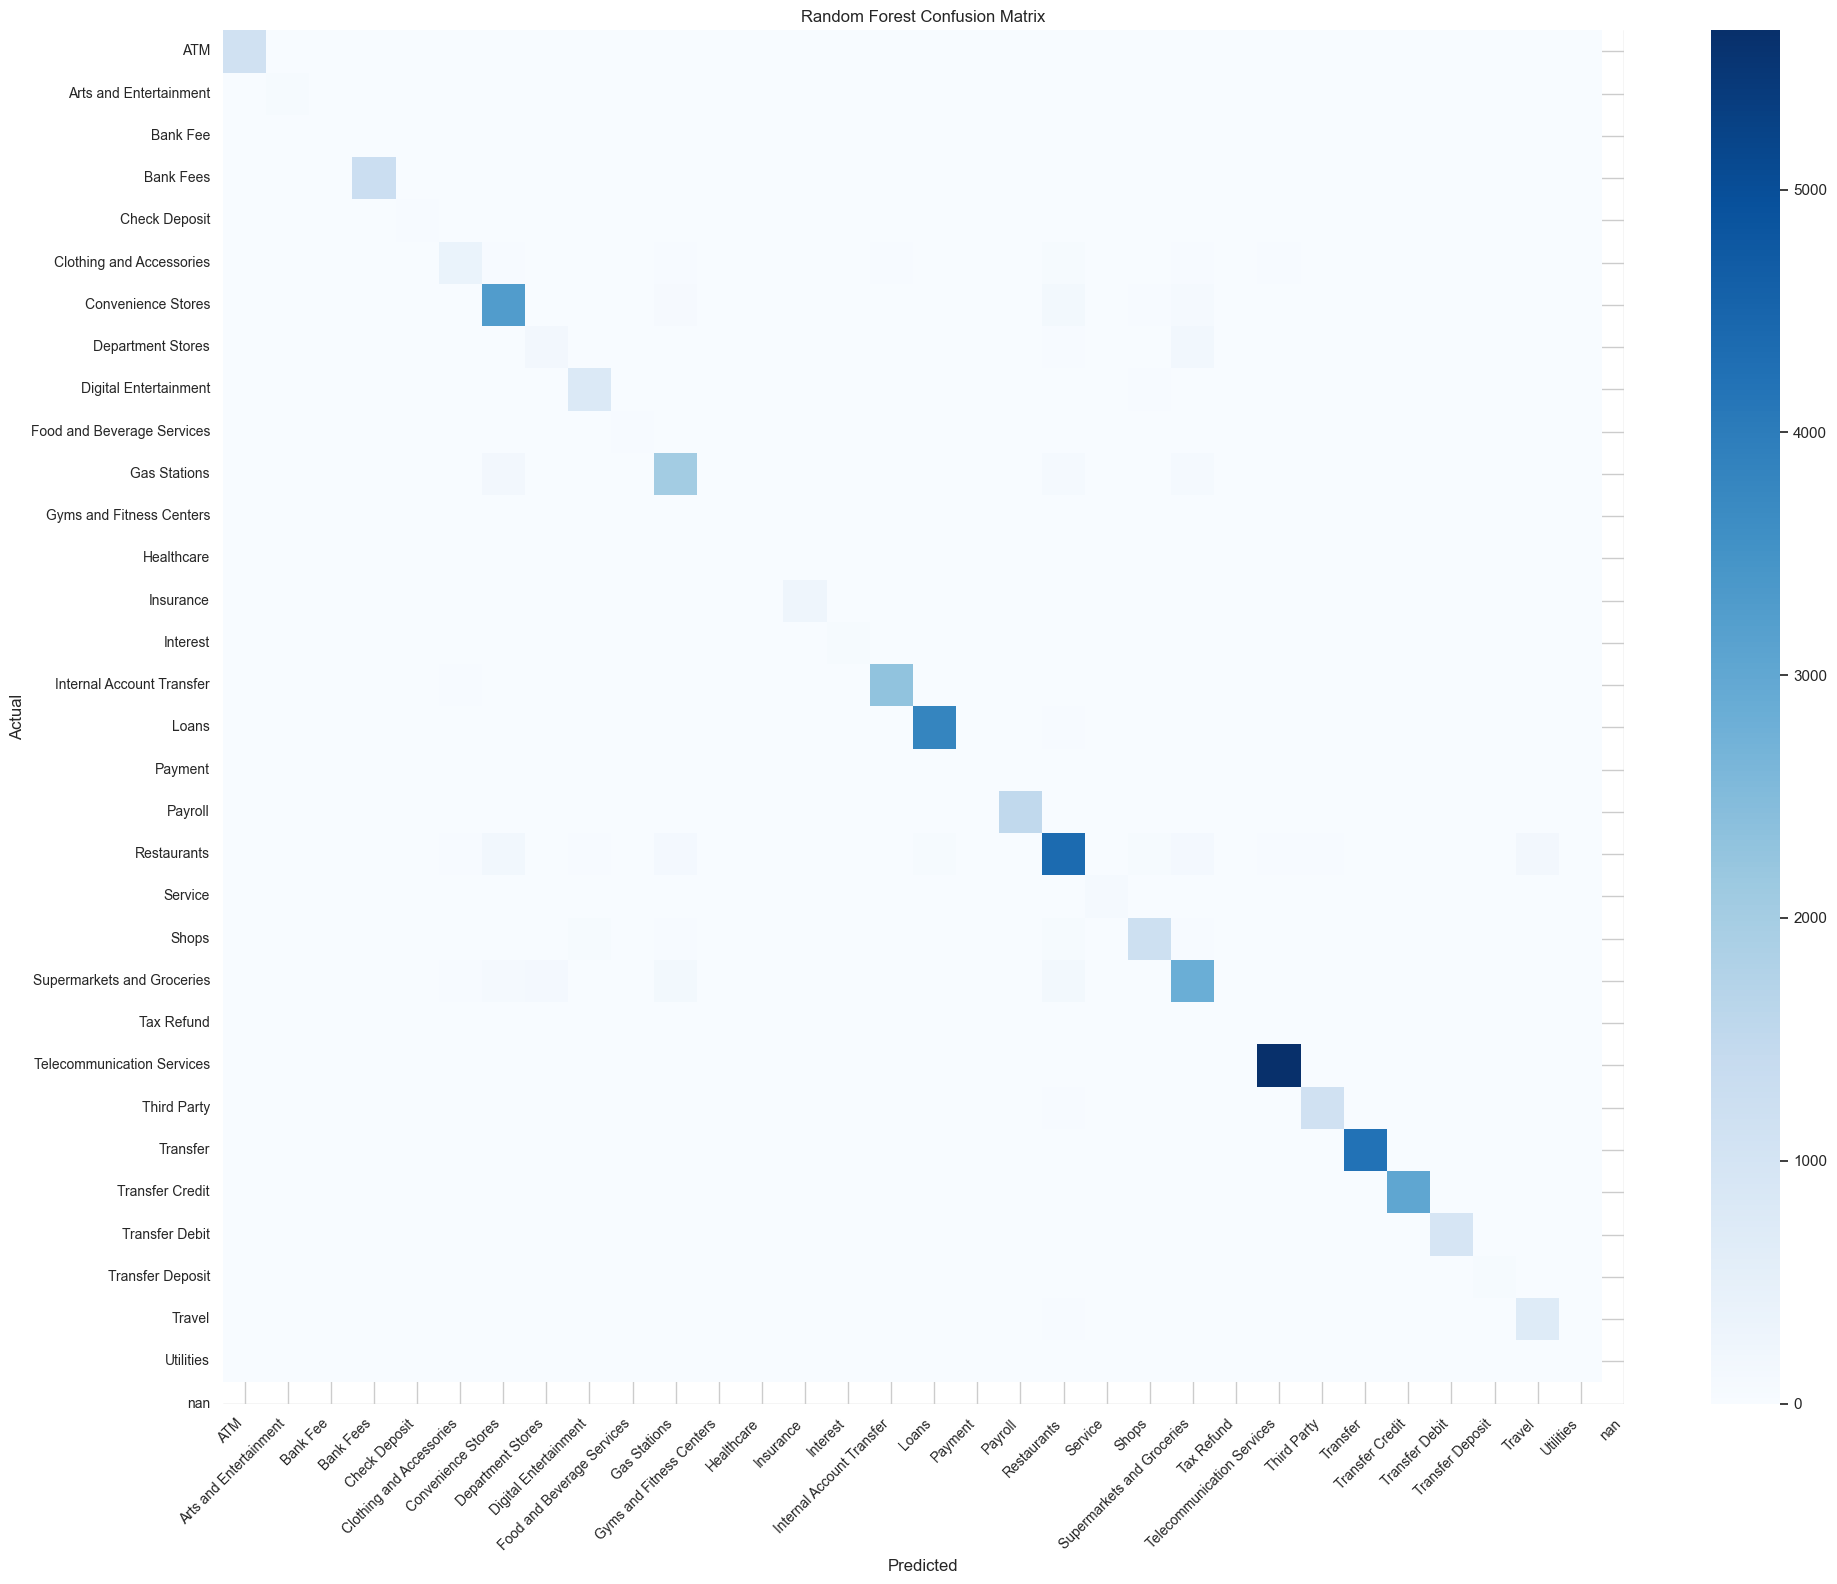

In [24]:
from sklearn.metrics import confusion_matrix

#confusion matrix for random forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(20, 16))
sns.heatmap(cm_rf, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Im using confusion matrix because its one of the best tools to determine whether the model understands the category for classification models. This tool breaks down which categories were predicted correctly and the model confusion

This plot shows high accuracy where all the high intensity is along the diagonal. There are a few misclassifications and there is no totally white rows and columns.

Also, since all rows and columns are colored, no class is being totally ignored or missed in the training

I have high confidence that this model will perform well based on this graph and the previous 3 indicators

**PREDICT "Uncategorized" TRANSACTIONS**

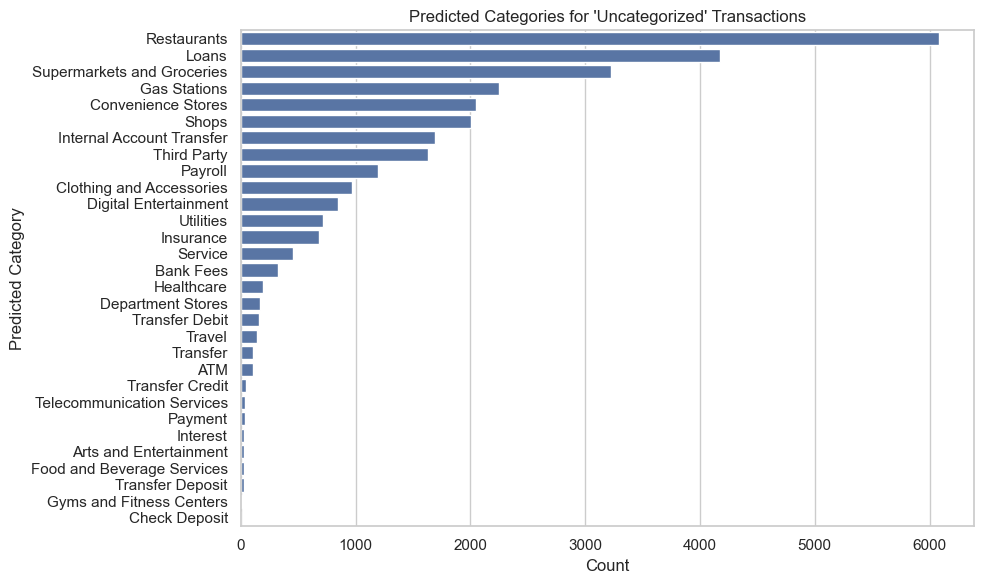

In [26]:
#reload data and merge
all_data = pd.read_csv('Data/bank_transaction.csv')
uncategorized = all_data[all_data['category'] == 'Uncategorized'].copy()
uncategorized = pd.merge(uncategorized, profiles, on='client_id', how='left')

#feature engineering
uncategorized[interests_columns] = uncategorized[interests_columns].astype(int)

#feature transformation
X_uncat_amount = scaler.transform(uncategorized[['amount']].values)
X_uncat_user = uncategorized[interests_columns].values
X_uncat_text = vectorizer.transform(uncategorized['description'])

#combine features
X_uncat = np.hstack((X_uncat_text.toarray(), X_uncat_amount, X_uncat_user))

#predict using random forest
uncategorized['predicted_category'] = le.inverse_transform(rf_model.predict(X_uncat))

#output results
uncategorized[['description', 'predicted_category', 'amount']].head(20)

plt.figure(figsize=(10, 6))
sns.countplot(y=uncategorized['predicted_category'], order=uncategorized['predicted_category'].value_counts().index)
plt.title("Predicted Categories for 'Uncategorized' Transactions")
plt.xlabel("Count")
plt.ylabel("Predicted Category")
plt.tight_layout()
plt.show()

**SUMMARY**

The model predicted likely categories with high accuracies such as
- CLOC ADVANCE -> Shops
- CHECK CARD REFUND -> Restaurants
- TARGET DEBI CARD -> Payroll

The model needs further refinement especially the **Empower** and **POS ADJUSTMENT -> Gas Stations**

**NEXT 1 MONTH**

- Try using GridSearchCV to improve model performance
- Add a new feature to see whether it helps with prediction
- Experiment with class imbalances techniques

**NEXT 3 MONTHS**

- Start learning and exploring deep learning model such as BERT
- Explore ways to further improve predictions

**REFLECTIONS**

As someone new to data science especially machine learning, this project helps me to understand real world scenarios on how predictions helps to produce better decisions. There are much to learn. I did struggle a bit when it come to analysis of this project especially user_profile dataset where I need to think hard from another perspective on why this data relevant to train a category predictive model.